In [208]:
import tensorflow as tf 
from tensorflow.keras import models , layers
import matplotlib.pyplot as plt 

In [209]:
#variables globales 

IMAGE_SIZE= 256
BATCH_SIZE = 32 
EPOCHS = 50
TRAIN_SIZE = 0.8
VALIDATION_SIZE= 0.5
CHANELS = 3
N_CLASES = 7



In [210]:
#Aqui estoy dandole las especificaciones de mi dataset.
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "data",
    shuffle= True,  #Esto es para que me arroje una imagen random.
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 1803 files belonging to 7 classes.


In [211]:
#Nombre de mis clases es practicamente el nombre de mis carpetas data -> (carpetas)

class_names = dataset.class_names
class_names

['bike', 'cars', 'cats', 'dogs', 'flowers', 'horses', 'human']

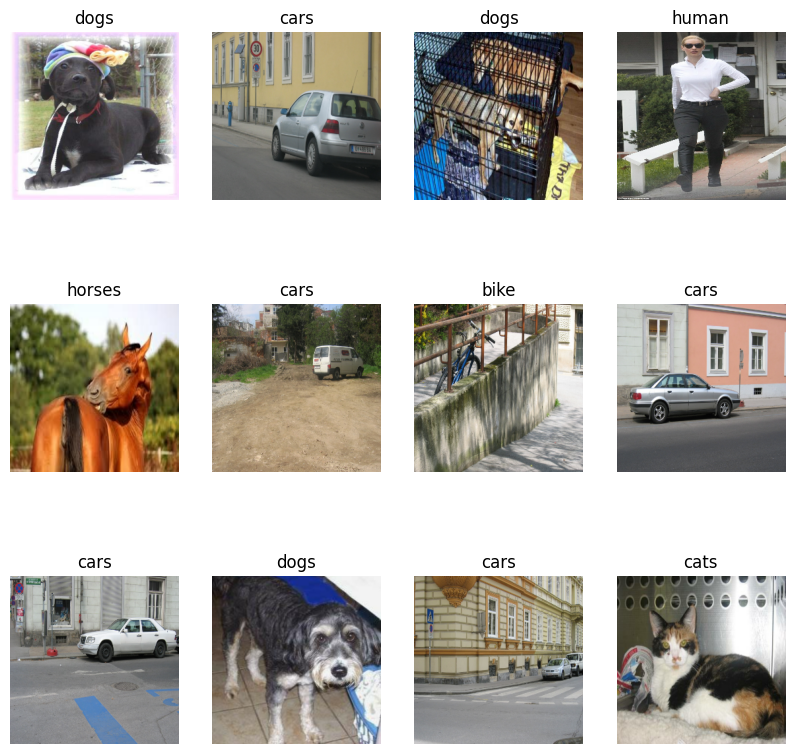

In [212]:

plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4, i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")
    #print(image_batch.shape)
    #print(label_batch.numpy())


In [213]:
#Vamos a agarrar los datos para entrenar  80% entrenar 10% validacion y 10% test

def get_dataset_prtitions(ds , train_size= TRAIN_SIZE , val_size= VALIDATION_SIZE, test_size= VALIDATION_SIZE , shuffle =True,shuffle_size = 10000):

    dataset_size = len(ds)

    if shuffle : 
        ds = ds.shuffle(shuffle_size, seed = 12)

    amount_train = int(dataset_size * train_size)
    amount_Val = int((dataset_size - amount_train) * val_size)

    train_ds = ds.take(amount_train)
    val_ds = ds.skip(amount_train).take(amount_Val)
    test_ds = ds.skip(amount_train).skip(amount_Val)
    return train_ds, val_ds, test_ds

train_dataset , val_dataset, test_datset = get_dataset_prtitions(dataset) # Funcion que me da los datos que deben ser segun si es para entrenar, validar o probar.



In [214]:
# vamos a darle performance a los datasets 
train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_dataset = val_dataset.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_datset = test_datset.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [215]:
#Vamos a recalcular el RGB de las imagenes
#Preprocesing.
INPUT_SHAPE1 = (IMAGE_SIZE, IMAGE_SIZE, CHANELS)

resize_and_rescale= tf.keras.Sequential([
    #layers.InputLayer(INPUT_SHAPE1),
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1.0/255)
])

In [216]:
#Preprocesing.
data_argumentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1)
])

In [217]:
base_model = tf.keras.applications.MobileNetV2(
    input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANELS),
    include_top = False, 
    weights =None
)
base_model.load_weights("mobilenet_v2_weights_tf_dim_ordering_tf_kernels_1.0_224_no_top.h5")
base_model.trainable = False

In [218]:
#Contruyendo el modelo
n_clases = len(class_names)
INPUT_SHAPE = (BATCH_SIZE,IMAGE_SIZE, IMAGE_SIZE, CHANELS)

model = models.Sequential([
    resize_and_rescale,
    data_argumentation,
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.3),
    layers.Dense(128, activation='relu'),
    layers.Dense(N_CLASES, activation='softmax')
])

model.build(input_shape= INPUT_SHAPE)

In [219]:
model.summary()

Model: "sequential_30"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_28 (Sequential)      │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_29 (Sequential)      │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_256            │ (32, 8, 8, 1280)       │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (32, 1280)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (32, 1280)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (32, 128)              │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (32, 7)                │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,855 (9.24 MB)

 Trainable params: 164,871 (644.03 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [220]:
model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005),
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy']
)

In [221]:
history = model.fit(
    train_dataset,
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    verbose = 1, 
    validation_data = val_dataset
)

Epoch 1/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 21s 414ms/step - accuracy: 0.5520 - loss: 1.3175 - val_accuracy: 0.9740 - val_loss: 0.1879
Epoch 2/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 21s 469ms/step - accuracy: 0.8878 - loss: 0.3380 - val_accuracy: 0.9740 - val_loss: 0.1324
Epoch 3/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 19s 426ms/step - accuracy: 0.9229 - loss: 0.2235 - val_accuracy: 0.9635 - val_loss: 0.1030
Epoch 4/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 19s 426ms/step - accuracy: 0.9391 - loss: 0.1946 - val_accuracy: 0.9792 - val_loss: 0.0766
Epoch 5/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 20s 452ms/step - accuracy: 0.9535 - loss: 0.1562 - val_accuracy: 0.9792 - val_loss: 0.0635
Epoch 6/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 22s 489ms/step - accuracy: 0.9662 - loss: 0.1065 - val_accuracy: 0.9844 - val_loss: 0.0538
Epoch 7/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 21s 466ms/step - accuracy: 0.9432 - loss: 0.1767 - val_accuracy: 0.9792 - val_loss: 0.0627
Epoch 8/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 22s 479ms/step - accuracy: 0.9521 - loss: 0.1362 - val_accu

In [222]:
scores = model.evaluate(test_datset)
scores

6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 315ms/step - accuracy: 0.9891 - loss: 0.0699


[0.08394822478294373, 0.984375]

In [223]:
acc = history.history['accuracy']
val_cc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

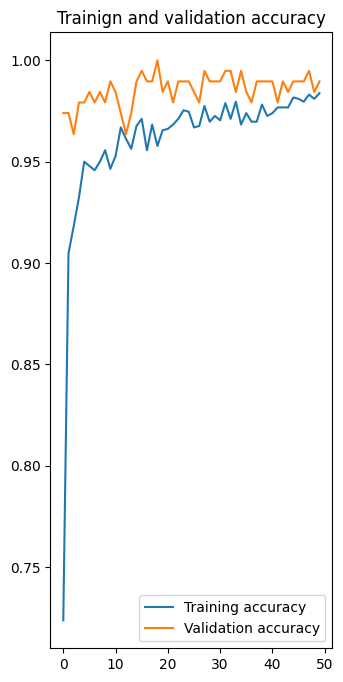

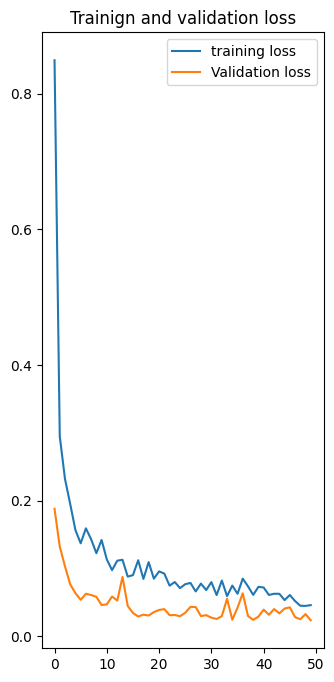

In [224]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label= 'Training accuracy')
plt.plot(range(EPOCHS), val_cc, label= 'Validation accuracy')
plt.legend(loc='lower right')
plt.title('Trainign and validation accuracy')

plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), loss, label= 'training loss')
plt.plot(range(EPOCHS), val_loss, label= 'Validation loss')
plt.legend(loc='upper right')
plt.title('Trainign and validation loss')
plt.show()

First image to predict
First image actual label:  flowers
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
predicted label: flowers


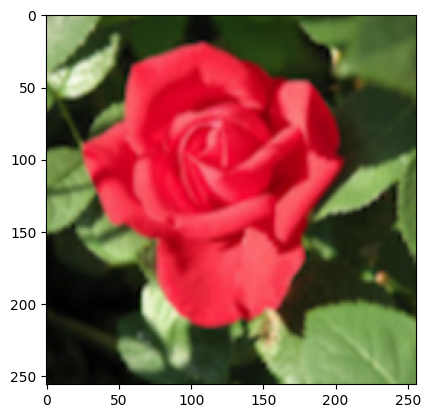

In [225]:
#Probar modelo 
import numpy as np 

for image_batch, label_batch in test_datset.take(1): 
    first_image = image_batch[0].numpy().astype('uint8')
    first_label = label_batch[0].numpy()

    print("First image to predict")
    plt.imshow(first_image)
    print("First image actual label: ", class_names[first_label])

    batch_predict = model.predict(image_batch)
    print("predicted label:", class_names[np.argmax(batch_predict[0])])

In [226]:
def predict(model, image): 
    images_array = tf.keras.preprocessing.image.img_to_array(image.numpy())
    images_array = tf.expand_dims(images_array, 0)

    predictions = model.predict(images_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    cofidence = round(100 * (np.max(predictions[0])), 2)

    return predicted_class, cofidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


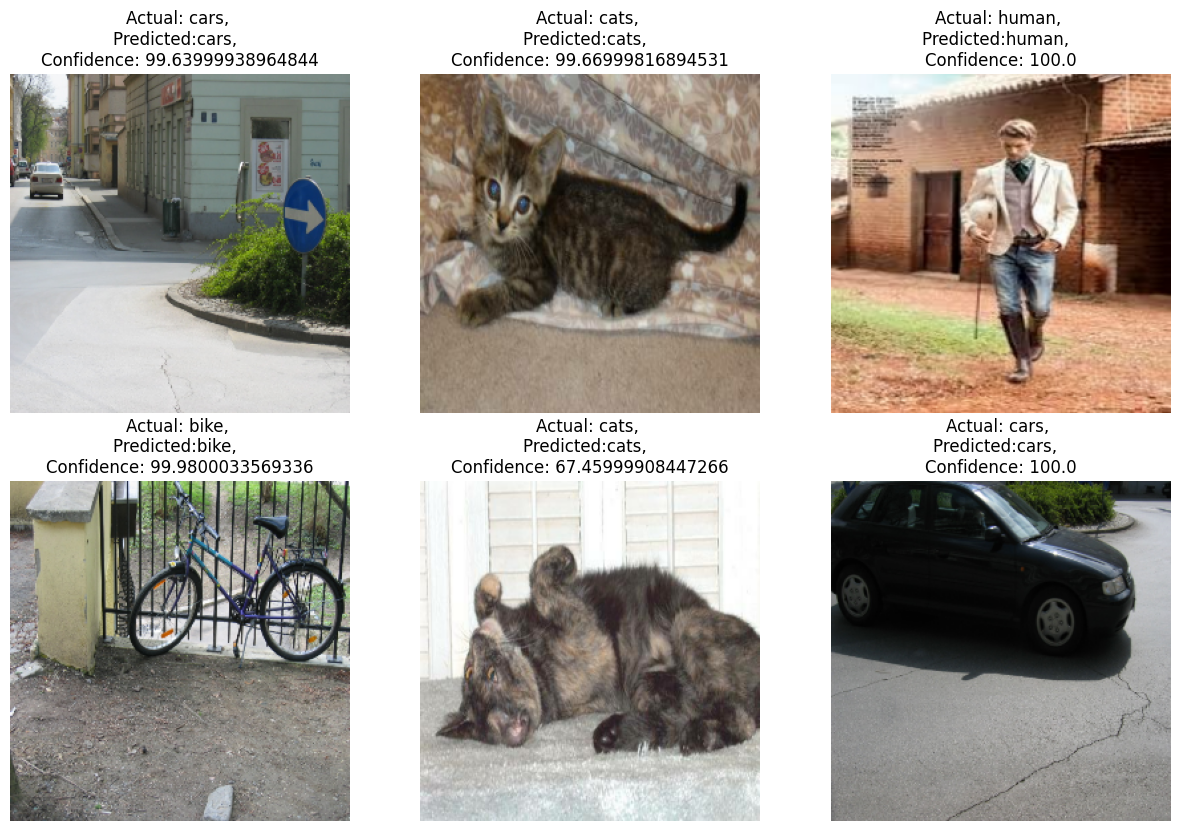

In [227]:

plt.figure(figsize=(15,15))
for images, labels in test_datset.take(1):
        for i in range(6):
            ax = plt.subplot(3,3,i+1)
            plt.imshow(images[i].numpy().astype('uint8'))

            predicted_class, confidence = predict(model, images[i])
            actual_class =class_names[labels[i]]

            plt.title(f"Actual: {actual_class}, \nPredicted:{predicted_class},  \nConfidence: {confidence}")

            plt.axis("off")

In [230]:
#Estamos guardando el modelo.
import os

model_version= 1
model.save(f"models/model_version_{model_version}/model.h5")